# Análise da utilização de Word2Vec nos anúncios

O objetivo é enontrar tanto um vocabulário em comum quanto melhorar a vetorização do algoritimo de clusterização.

## Preparando o ambiente

O código abaixo permite que o notebook enxergue as referências do projeto que ficam em pastas referenciadas pela pasta pai.

In [1]:
import sys
sys.path.append('../')

Todas as referências utilizadas no notebook estão referenciadas aqui nesta única célula. Não adicionar referências para uso específico durante o projeto para não desorganizar o código.

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import random
import logging
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import WhitespaceTokenizer
from nltk.cluster.util import cosine_distance
from os.path import exists
import pickle
from gensim.models import Phrases
from os import environ as env
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
from s_dbw import S_Dbw
from sklearn.feature_extraction.text import CountVectorizer

O método `skip-gram` precisa de uma variável de ambiente chamada `PYTHONHASHSEED` para controlar a aleatoriedade. Já outros métodos utilizam o `random` do python ou do numpy. Abaixo estamos configurando todos.

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
env['PYTHONHASHSEED'] = str(SEED)

## Carregando os dados

Foram 1438047 de anúncios encontrados para processamento. No entanto apenas 570312 sobraram para o processamento (~ 40%). Isso se deu devido aos seguintes tratamentos:

1. Remoção de anúncios que, após a exclusão das stopwords, não possuíam mais nenhuma palavra
2. Remoção de anúncios com texto duplicado (o que acontece com frequência em alguns tenants)
3. Remoção de anúncios que não tenham informação suficiente cadastrada do Tenant.

In [4]:
dataset = pd.read_csv('../data/ads_2022/preprocessed/ads_full.csv')
dataset.dropna(inplace=True)
dataset.shape

(570312, 7)

## Analisando os dados

### Distribuição dos anúncios por Company

In [5]:
def get_proportion(dataframe: pd.DataFrame, fields: list[str]) -> pd.DataFrame:
    new_columns = fields + ['ad_id']    
    company_distribution = dataframe.groupby(fields).count().reset_index()[new_columns].rename(columns={'ad_id': 'count'})
    total_ads = company_distribution['count'].sum()
    company_distribution['percentage'] = company_distribution['count'].apply(lambda x: x / total_ads)
    return company_distribution.sort_values(by='percentage', ascending=False).reset_index()

In [6]:
get_proportion(dataset, ['company_name', 'tenant_id'])

,index,company_name,tenant_id,count,percentage
0,47,Magalu,5c9386f9504d3100012e95e5,109151,0.191388
1,75,Via varejo,5c4b20593e77dc00011399d9,71412,0.125216
2,6,Americanas,5ea6d0c40e82150001b22fc2,55755,0.097762
3,45,Lojas Lebes,5eb9d68c0e82150001b23013,53809,0.094350
4,79,Zema,5c2671aa57f05500012a2eee,40289,0.070644
...,...,...,...,...,...
75,29,Directseg,62190f3ac86635f02e35430e,5,0.000009
76,13,Bornlogic 12,5bababaa708b8413441ffa4f,4,0.000007
77,34,Fontes,61eefb69a4764ca5826caf8f,3,0.000005
78,76,Vivo Ad Credits,6172ca19eb15e74f998fd395,3,0.000005


Mais de 58% dos anúncios estão concentrados nos 5 primeiros tenants (Magalu, Via Varejo, Americanas, Lebes e Zema).

### Distribuição dos anúncios por Tipo

In [7]:
get_proportion(dataset, ['company_type'])

,index,company_type,count,percentage
0,2,Varejo,526813,0.923728
1,1,Serviços,42905,0.075231
2,0,Industria,594,0.001042


Mais de 92% dos anúncios são de varejo.

### Distribuição dos anúncios por Segmento

In [8]:
get_proportion(dataset, ['company_segment'])

,index,company_segment,count,percentage
0,3,Eletromóveis,326341,0.572215
1,8,Lojas de departamento e mercadorias,69791,0.122373
2,15,"Super, Hiper, Atacarejo e Conveniencia",66030,0.115779
3,9,"Moda, Calçados e Artigos Esportivos",52516,0.092083
4,4,Financeiro,18487,0.032416
5,2,Educação,15663,0.027464
6,1,"Cosméticos, perfumaria e farmácia",10099,0.017708
7,17,Telecomunicações,4872,0.008543
8,10,Real Estate,2533,0.004441
9,0,Concessionárias (Auto/Moto),1381,0.002421


Mais da metade (57%) dos anúncios estão concentrados em empressas classificadas no segmento "Eletromóveis". Já a outra metade é dividida entre Lojas de departamento, mercados e moda (33% do total) e outros segmentos (~ 10%).

É possível notar que existe um viés claro nos dados dos anúncios utilizados aqui. Isso pode ser um problema para todos os modelos seguintes em tenants que não sejam de Varejo.

## Modelando com Word2Vec

Como o tratamento do texto já foi realizado anteriormente, a tokenização utilizada aqui é a simples quebra por espaço.

In [9]:
tokenizer = WhitespaceTokenizer()
tokenized_docs = [tokenizer.tokenize(ad_text) for ad_text in dataset['cleaned_text'] ]
print(len(tokenized_docs))

570312


Antes de criar o modelo, separamos o texto em sentensas utilizando a class `Phrases` que também permite trabalhar com bigramas no texto. A bigrama é definida como um novo token, onde os dois tokens anteriores são unidos por um `_`.

In [120]:
bigram_transformer = Phrases(tokenized_docs, min_count=10)

Abaixo temos a criação de um modelo `Word2Vec` com o método `skip-gram` e com 100 dimensões. O modelo foi treinado com 20 épocas.
Além disso, o modelo está configurado para apenas considerar tokens que apareçam mais de 10 vezes no corpus e também para registrar o `loss`.

São também configurados 8 workers para o processamento em paralelo.

> Foram realizados testes com CBOW, vetores maiores e número de épocas maiores e menores. A configuração abaixo foi a que apresentou os melhores resultados observados e gerando um modelo razoavelmente pequeno (arquivo de vetores em torno de 20MB).

In [121]:
ngram_model = Word2Vec(
    sentences=bigram_transformer[tokenized_docs], 
    sg=1,
    vector_size=100, 
    workers=8, 
    seed=SEED, 
    min_count=10, 
    epochs=20, 
    compute_loss=True
)

O treinamento acima leva em torno de 10 minutos para rodar.

Para efeitos de comparação, abaixo um mesmo modelo mas sem o uso de bigramas.

In [122]:
simple_model = Word2Vec(
    sentences=tokenized_docs,
    sg=1,
    vector_size=100, 
    workers=8, 
    seed=SEED, 
    min_count=10, 
    epochs=20, 
    compute_loss=True
)

### Experimentando os modelos

O método abaixo encontra as `topn` palavras mais similares a uma dada palavra ou lista de palavras.
Também é possível encontrar palavras que não são similares a uma dada palavra ou lista de palavras no parâmetro negative.

In [123]:
words = ['smartphone', 'samsung', 'motorola', 'iphone', 'acer', 'notebook', 'lenovo', 'xiaomi', 'arfryer', 'lavadora', 'geladeira', 'consul']

def print_similar(model: Word2Vec, word: str):
    print(f'\n\n *** Palavras similares a {word} *** \n')
    for similar_word, similarity in model.wv.most_similar(word, topn=10):
        print(f'{similar_word} - {similarity}')

#### Modelo com Bigramas

In [124]:
for word in words:
    print_similar(ngram_model, word)



 *** Palavras similares a smartphone *** 

celular - 0.8079062104225159
smartphones - 0.7798966765403748
celulares - 0.7388275861740112
motorola - 0.7320172786712646
troqueseucelular - 0.7097023725509644
smartphone_motorola - 0.7022383809089661
smartphone_samsung - 0.6964427828788757
telefonia - 0.6901738047599792
trocar_smartphone - 0.6849275827407837
smatphone - 0.6748748421669006


 *** Palavras similares a samsung *** 

motorola - 0.7856016755104065
sansung - 0.7516082525253296
samsumg - 0.735723614692688
acer_lenovo - 0.7317425608634949
galaxy - 0.7285083532333374
acer - 0.7206438779830933
tcl - 0.7175400257110596
a03core - 0.7158241868019104
tcltv - 0.7075546979904175
notebook_acer - 0.70713871717453


 *** Palavras similares a motorola *** 

samsung - 0.7856016755104065
smartphone_motorola - 0.7679975628852844
motog - 0.7549338936805725
a23 - 0.7455610036849976
motorola_motorola - 0.7326964735984802
smartphone - 0.7320173382759094
g22 - 0.7284142971038818
positivo_multilaser -

#### Modelo simples

In [125]:
for word in words:
    print_similar(simple_model, word)



 *** Palavras similares a smartphone *** 

celular - 0.7958705425262451
smartphones - 0.7677938938140869
motorola - 0.6955063939094543
sansung - 0.6934441924095154
samsung - 0.6933012008666992
a32 - 0.6808217763900757
troqueseucelular - 0.6729292869567871
notebook - 0.671934962272644
smarttv - 0.666790246963501
a03 - 0.6615244150161743


 *** Palavras similares a samsung *** 

motorola - 0.8498696684837341
a13 - 0.8368636965751648
a03 - 0.809364378452301
a32 - 0.8089965581893921
galaxy - 0.7982056736946106
s20 - 0.7874330282211304
a23 - 0.771888792514801
a12 - 0.7667020559310913
a52 - 0.7610216736793518
a53 - 0.7558366656303406


 *** Palavras similares a motorola *** 

samsung - 0.8498696684837341
a13 - 0.757515013217926
g22 - 0.7566375732421875
g52 - 0.7516529560089111
g60s - 0.7325477600097656
sansung - 0.7318364381790161
a03 - 0.7287513017654419
galaxya13 - 0.7265475988388062
nokia - 0.7180981040000916
g31 - 0.7167720794677734


 *** Palavras similares a iphone *** 

iphoneday - 

Possivelmente para a **clusterização** o modelo com bigramas performe melhor, mas para uso em API de vocabulário, o modelo simples é melhor, visto que apresenta menos dados redundantes.

#### Possibilidades com modelos

Abaixo algumas possibilidades de uso do Word2Vec. Será utilizado apenas o modelo com bigramas, mas o uso se dá da mesma forma para o modelo simples.

##### Calculando similaridade entre duas palavras

In [103]:
ngram_model.wv.similarity('smartphone', 'celular')

0.80790627

##### Método alternativo para similaridade

In [127]:
ngram_model.wv.most_similar_cosmul(['samsung', 'smartphone'], topn=20)

[('motorola', 0.7731724977493286),
 ('smartphones', 0.7354727387428284),
 ('celular', 0.7303162217140198),
 ('celulares', 0.7265018820762634),
 ('sansung', 0.7207329273223877),
 ('smartphone_samsung', 0.7134494781494141),
 ('smartphone_motorola', 0.711828351020813),
 ('a23', 0.7040438652038574),
 ('motorola_nokia', 0.703444242477417),
 ('samsung_motorola', 0.698502242565155),
 ('a03core', 0.6958571672439575),
 ('troqueseucelular', 0.6949499845504761),
 ('samsung_a53', 0.6942026019096375),
 ('samsumg', 0.6910018920898438),
 ('galaxya13', 0.6908678412437439),
 ('a13', 0.6908193826675415),
 ('sansumg', 0.6856268644332886),
 ('m52', 0.6839920878410339),
 ('g22', 0.6801782846450806),
 ('samsung_galaxy', 0.6794378161430359)]

Note que os pesos desse método são um pouco maiores, visto que ele utiliza formas diferente de aproximação e tem mais "certeza" da similariade

##### Identificando palavras não similares

In [8]:
ngram_model.wv.doesnt_match(['samsung', 'motorola', 'celular', 'lavadora', 'asdfqwer'])

10:17:16: vectors for words {'asdfqwer'} are not present in the model, ignoring these words


'lavadora'

Acima, a palavra `lavadora` é a com menor relação entre todas, não pertencendo ao grupo fornecido.

##### Lista de palavras mais próximas a uma dada palavra que outra

In [112]:
ngram_model.wv.closer_than('samsung', 'celular')

['smartphone',
 'smartphones',
 'celulares',
 'motorola',
 'notebook',
 '128gb',
 'samsung_galaxy',
 'smarttv',
 'smartphone_samsung',
 'electrolux',
 'polegadas',
 'televisao',
 'tcl',
 'samsung_motorola',
 'smartphone_motorola',
 'smart_samsung',
 'jbl',
 'televisor',
 'ram',
 'galaxy',
 'smartv',
 'a32',
 'g22',
 'a13',
 'aoc',
 's20',
 'lenovo',
 'smart_led',
 'tvsmart',
 'caixadesom',
 'nokia',
 'sansung',
 'a03',
 'samsung_a32',
 's20fe',
 'samsung_s22',
 'a23',
 'notebook_asus',
 'lavaeseca',
 'uhd',
 'samsung_s20',
 'a33',
 'asus',
 'tvsamsung',
 'cartao_cartaomastercard',
 'caixaamplificada',
 'g60',
 'a52',
 'tv4k',
 'samsumg',
 'toshiba',
 'boxplumatex_boxcasal',
 'boxqueensize_ofertabox',
 'a12_64gb',
 'a53',
 'motog',
 'tv50',
 'acer',
 'samsunggalaxy',
 's22_samsung',
 'galaxy_a23',
 'lavadoraelectrolux12kg_ofertasarrasadoras',
 'g31',
 'a03core',
 'm52',
 'samsung_a52',
 'tv55',
 'a13_samsung',
 'e20',
 'nanocell',
 '8gb_ram',
 'tcltv',
 'galaxy_a52',
 'motog20',
 'galax

##### Qual a palavra mais próxima a uma lista de palavras

In [107]:
ngram_model.wv.most_similar_to_given('samsung', ['motorola', 'celular', 'lavadora'])

'motorola'

##### Ranking entre palavras

Ranking de uma palavra em relação a outra em proximidade.

In [108]:
ngram_model.wv.rank('celular', 'smartphone')

1

In [110]:
ngram_model.wv.rank('celular', 'fruta')

42849

## Salvando os modelos

De acordo com a documentação:

> The reason for separating the trained vectors into KeyedVectors is that if you don’t need the full model state any more (don’t need to continue training), its state can be discarded, keeping just the vectors and their keys proper.

Ou seja, caso não deseje novos treinamentos para o modelo, basta salvar apenas o `model.wv` que contém os vetores e suas chaves.

Pode ser feito:

```python
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

vector = wv['computer']  # Get numpy vector of a word
```

Dessa forma, o modelo consome muito menos espaço para armazenamento e memória ram para ser carregado. Para colocar em produção, talvez o ideal seja salvar os dois, mas utilizar apenas o vetor.

Além disso, os métodos `save` utilizam internamente a biblioteca `pickle`.

In [130]:
ngram_model.save('../data/ads_2022/word2vec_model/word2vec_100_ngram.model')
simple_model.save('../data/ads_2022/word2vec_model/word2vec_100.model')

ngram_model.wv.save('../data/ads_2022/word2vec_model/word2vec_100_ngram.wv')
simple_model.wv.save('../data/ads_2022/word2vec_model/word2vec_100.wv')

In [6]:
ngram_model = Word2Vec.load('../data/ads_2022/word2vec_model/word2vec_100_ngram.model')
simple_model = Word2Vec.load('../data/ads_2022/word2vec_model/word2vec_100.model')

ngram_vector = KeyedVectors.load('../data/ads_2022/word2vec_model/word2vec_100_ngram.wv')
simple_vector = KeyedVectors.load('../data/ads_2022/word2vec_model/word2vec_100.wv')

10:16:52: loading Word2Vec object from ../data/ads_2022/word2vec_model/word2vec_100_ngram.model
10:16:52: loading wv recursively from ../data/ads_2022/word2vec_model/word2vec_100_ngram.model.wv.* with mmap=None
10:16:52: setting ignored attribute cum_table to None
10:16:53: Word2Vec lifecycle event {'fname': '../data/ads_2022/word2vec_model/word2vec_100_ngram.model', 'datetime': '2023-02-13T10:16:53.047486', 'gensim': '4.3.0', 'python': '3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}
10:16:53: loading Word2Vec object from ../data/ads_2022/word2vec_model/word2vec_100.model
10:16:53: loading wv recursively from ../data/ads_2022/word2vec_model/word2vec_100.model.wv.* with mmap=None
10:16:53: setting ignored attribute cum_table to None
10:16:53: Word2Vec lifecycle event {'fname': '../data/ads_2022/word2vec_model/word2vec_100.model', 'datetime': '2023-02-13T10:16:53.304567', 'gensim': '4.3.0', 'p

### Consumindo o dicionário dos vetores carregados

In [132]:
# Dicionário das palavras utilizadas - vocabulário
'lavadora' in simple_vector.key_to_index

True

Abaixo é possível observar o vetor gerado para a palavra:

In [133]:
simple_vector['smartphone']

array([-0.38484028, -0.6572288 , -0.14744078, -0.18379757, -0.2960514 ,
       -0.03425425,  0.8167372 ,  0.4786531 ,  0.23476033, -0.08393216,
        0.04763038,  0.28473428,  0.41781002,  0.6252697 , -0.30713055,
        0.6961318 , -0.3927612 , -0.47692257,  0.09585433,  0.44653207,
        0.3599962 ,  0.11790296, -0.26622942,  0.02334156, -0.15762755,
       -0.381878  , -0.27346295, -0.36799154, -0.32047182,  0.1527832 ,
        0.7005383 , -0.39008474,  0.06827886, -0.5345552 ,  0.01235103,
       -0.22823425,  0.12909237, -0.39197755,  0.13586482,  0.0304972 ,
        0.2623397 ,  0.23790662, -0.10114253, -0.26417112, -0.6393438 ,
       -0.27206275, -0.11496433,  0.49280447,  0.25345778,  0.09168054,
       -0.01355151, -0.09803419,  0.41401538,  0.705238  ,  0.2577733 ,
        0.35940745,  0.209846  , -0.04814927, -0.11127543,  0.99837697,
       -0.24745998, -0.552586  , -0.14084771,  0.31452346,  0.14553414,
        0.52682155,  0.02948772, -0.39211515, -0.07934252, -0.03

## Treinamento contínuo

Conforme pode ser visto abaixo, é possível realizar o treino contínuo do modelo ao adicionar novas frases. No entanto esse treino só pode se realizado sobre o modelo `Word2Vec`. Vetores não podem ser retreinados.

In [134]:
more_sentenses = [
    'corre cozinha sonhos corredicas telescopicas linda cristaleira reais descontos compra mesa cadeiras linho desconto imperdivel soatedomingo piratuba',
    'gente trouxe super novidade curtir inverno panela eletrica fondue'
]

splited_sentenses = [sentence.split(' ') for sentence in more_sentenses]
simple_model.build_vocab(splited_sentenses, update=True)
simple_model.train(splited_sentenses, total_examples=simple_model.corpus_count, epochs=2)
simple_model.wv.most_similar('cristaleira')

[('kappesberg', 0.6620039343833923),
 ('cobogo', 0.6396653652191162),
 ('lotus', 0.6386463046073914),
 ('telescopicas', 0.6351643800735474),
 ('fosca', 0.6302306652069092),
 ('modulada', 0.6250993013381958),
 ('corredicas', 0.6214839220046997),
 ('poliman', 0.6178778409957886),
 ('pia', 0.6059314608573914),
 ('sevilha', 0.6025501489639282)]

## Visualizando os vetores

Para fins de visualização e simplificação, vamos utilizar apenas o modelo simples, sem bigramas, para a visualização. A visualização se dá por meio da redução de dimensionalidade dos vetores utilizando a técnica `TSNE`.

In [84]:
ngram_model.wv.vectors

array([[-2.4617919e-01,  3.7430529e-02,  1.9315998e-01, ...,
         5.0927418e-01,  1.7548772e-02, -2.4499406e-01],
       [ 1.4978780e-01, -1.6189803e-01,  2.7355710e-01, ...,
        -6.7263916e-02, -2.9857111e-01,  3.3346653e-01],
       [-1.8404964e-01, -5.2777681e-02, -7.5714290e-02, ...,
         2.3784842e-01, -2.2239959e-01, -2.4157886e-01],
       ...,
       [-2.6471287e-01, -1.8090187e-01, -8.2242405e-03, ...,
         3.4327916e-04, -5.2871329e-01,  2.6035124e-01],
       [ 4.4811392e-01,  3.4959906e-01, -1.3934028e-01, ...,
         1.3490403e-01,  1.4401405e-01,  1.8983686e-02],
       [ 1.3340446e-02,  3.5815647e-01, -4.7454736e-01, ...,
         3.7317523e-01,  1.4810154e-01,  4.8216242e-01]], dtype=float32)

In [83]:
def reduce_vectors_dimensions(vectors: np.ndarray, final_num_dimensions: int = 2):
    tsne = TSNE(n_components=final_num_dimensions, random_state=SEED)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals

def reduce_dimensions(model: Word2Vec, final_num_dimensions: int = 2):
    vectors = np.asarray(model.wv.vectors)
    words = np.asarray(model.wv.index_to_key)
    
    x_vals, y_vals = reduce_vectors_dimensions(vectors, final_num_dimensions)
    return x_vals, y_vals, words    

Dois tipos de plot são implementados: um com `matplotlib` para visualização direta no notebook e outro com `plotly` para visualização em um arquivo html interativo.

In [94]:
def plot_html_with_plotly(x_vals: list, y_vals: list, words: list, filename: str = 'ads_word2vec_plot.html'):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=words)
    data = [trace]

    plot(data, filename=filename)

In [138]:
def plot_with_matplotlib(x_vals: list, y_vals: list, words: list):
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(words)))
    selected_indices = random.sample(indices, 15)
    for i in selected_indices:
        plt.annotate(words[i], (x_vals[i], y_vals[i]))

A classe abaixo permite que o arquivo com as dimensões reduzidas seja salvo, evitando assim reprocessamento em qualquer alteração da visualização.

In [86]:
class ReducedDimensions:
    def __init__(self, x_vals: list, y_vals: list, labels: list):
        self.x_vals = x_vals
        self.y_vals = y_vals
        self.labels = labels

In [87]:
def load_reduced_dimensions(model: Word2Vec, filename = '../data/ads_2022/word2vec_model/word2vec_vocabulary_reduced_dimensions.pkl') -> ReducedDimensions:    
    if exists(filename):
        with open(filename, 'rb') as file:
            return pickle.load(file)
    else:
        x_vals, y_vals, labels = reduce_dimensions(model)
        reduced = ReducedDimensions(x_vals, y_vals, labels)
        pickle.dump(reduced, open(filename, 'wb'))
        return reduced

In [142]:
loaded_reduced = load_reduced_dimensions(simple_model)

c:\Users\salat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\salat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



A execução acima pode levar vários minutos para ser executada.

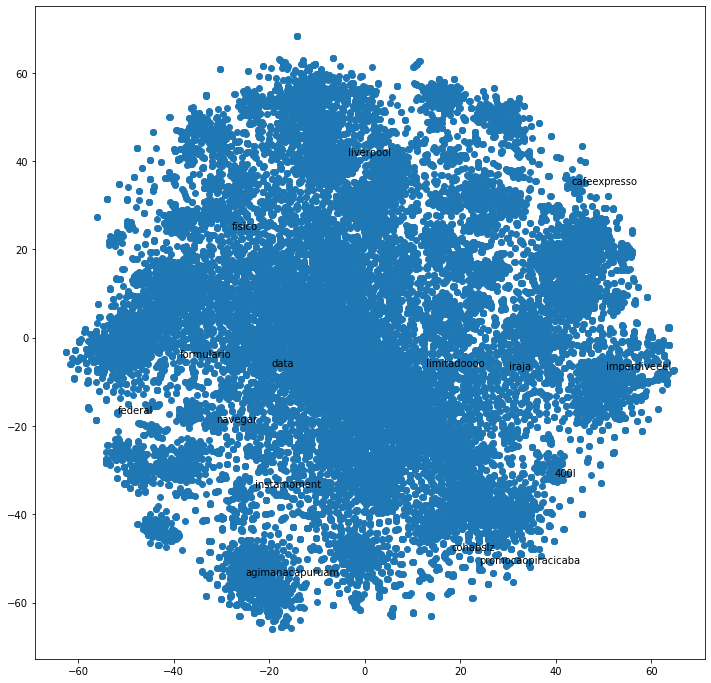

In [143]:
plot_with_matplotlib(loaded_reduced.x_vals, loaded_reduced.y_vals, loaded_reduced.labels)

A execução abaixo irá abrir um HTML com o gráfico.

In [144]:
plot_html_with_plotly(loaded_reduced.x_vals, loaded_reduced.y_vals, loaded_reduced.labels)

## Clusterização de documentos com `Word2Vec`

Como Word2Vec é um modelo de representação de palavras, podemos utilizar esse modelo para representar documentos. Para isso, podemos utilizar a média dos vetores das palavras que compõem o documento. A média para uma sentença pode ser obtida:

In [6]:
ngram_model.wv.get_mean_vector(['samsung', 'compre', 'gosto', 'blablabla', 'smartphone'], ignore_missing=True)

array([ 1.29415281e-02,  2.84196585e-02, -6.73374757e-02,  2.07686499e-02,
       -9.43069607e-02,  6.21129721e-02,  7.74239600e-02,  1.52826235e-01,
        3.69955450e-02, -5.93491904e-02, -4.87604588e-02,  4.26598340e-02,
       -7.20713288e-05,  4.92530316e-02, -7.89748132e-03, -1.67424932e-01,
        5.76995574e-02, -1.27557725e-01,  1.07646007e-02,  3.47392261e-02,
        5.89211993e-02,  8.28816220e-02, -2.61530988e-02,  1.80305600e-01,
        6.30835742e-02, -3.64513323e-02,  1.15878284e-01,  1.78793408e-02,
        1.61563084e-02, -3.80696841e-02, -7.59141054e-03, -5.50234728e-02,
       -3.82040516e-02,  5.66851348e-02,  6.51577562e-02, -4.75699194e-02,
        2.98956912e-02, -5.95390201e-02, -9.85306054e-02,  4.56667393e-02,
        3.08303572e-02,  2.55644657e-02,  8.48574564e-02,  6.46615922e-02,
        3.99480984e-02,  3.02595459e-03,  8.39364827e-02,  5.32218330e-02,
        1.13994315e-01, -2.49665286e-02, -6.51311278e-02, -6.26033992e-02,
       -8.65134969e-02,  

Note que o parâmetro `ignore_missing` é utilizado para ignorar palavras que não estão no vocabulário do modelo. Caso ele seja `False`, uma exceção será lançada quando uma palavra não estiver no vocabulário. Abaixo o código para a transformação dos documentos em vetores utilizando a média dos vetores das palavras que compõem o documento.

In [11]:
vectorized_docs = np.array([ngram_model.wv.get_mean_vector(document, ignore_missing=True) for document in tokenized_docs])

Tentei utilizar a versão do KMeans do `nltk`, mas era muito lento. Já a versão do `scikit-learn` é muito mais rápida, conforme pode ser visto no código abaixo.

In [19]:
kmeans_model = KMeans(n_clusters=30, random_state=SEED)
kmeans_model.fit(vectorized_docs)

KMeans(n_clusters=30, random_state=42)

In [22]:
cluster_response = kmeans_model.predict(vectorized_docs)
print(cluster_response)

[20 20 14 ...  0  6 26]


### Avaliando o modelo

A avaliação do modelo pode ser feita por diversos métodos que consideram aspectos diferentes da clusterização. 

#### S_Dbw

Quanto menor for o valor, melhor. Não tem um valor máximo bem definido.

In [47]:
def get_sdbw(vectors: np.ndarray, initial_k: int = 2, max_k: int = 30, step: int = 1):
    sum_of_squared_distances = []
    models = []
    sdbw_scores = []

    K = range(initial_k, max_k, step)
    for k in K:
        inertia, km, score = execute_kmeans(vectors, k)
        sum_of_squared_distances.append(inertia)
        models.append(km)
        sdbw_scores.append(score)
    
    return sum_of_squared_distances, models, sdbw_scores

def execute_kmeans(vectors, k: int):
    print(f'Running KMeans with k={k}')
    km = KMeans(n_clusters=k, random_state=SEED)
    km = km.fit(vectors)
    print(f'Finished KMeans with k={k}')
    prediction = km.predict(vectors)
    inertia = km.inertia_
    print(f'Calculating SDBW score for k={k}')
    score = S_Dbw(vectorized_docs, prediction, method='Halkidi', alg_noise='bind')
    print(f'SDBW score for k={k}: {score}\n\n')
    return inertia, km, score

In [ ]:
ssd, models, scores = get_sdbw(vectorized_docs, initial_k = 56, max_k = 60, step = 2)

In [27]:
ssd

[83695.78125, 76692.59375, 73289.0859375, 70872.015625]

In [40]:
scores

[0.8018628326362803, 0.7813395454958001, 0.7819669804741022]

In [41]:
best_model = {
    'model': models[1],
    'score': scores[1]    
}

Foram testados: 10, 20, 30, 40, 50, 56, 60, 62, 64, 66, 68, 70, 80, 200, 300 clusters e o melhor resultado foi com 300 (score 0.7406). No entanto podem existir melhores resultados nos intervalos não testados, que precisariam de mais tempo para serem avaliados, visto que o teste d_sbw é muito custoso.

#### Elbow Plot

Um dos mais visuais é o método do cotovelo, que consiste em plotar o valor da função objetivo em função do número de clusters. A partir do gráfico, é possível identificar o ponto de "cotovelo", que é o número de clusters que apresenta a maior redução no valor da função objetivo. No entanto, esse método considera apenas a função objetivo, não considerando outros aspectos, como a própria densidade dos clusters. Outros métodos foram identificados através da leitura de papers que serão usados aqui.

In [20]:
def generate_elbow_plot(vectors: np.ndarray, initial_k: int = 2, max_k: int = 30, step: int = 1):
    sum_of_squared_distances = []
    K = range(initial_k, max_k, step)
    for k in K:
        print(f'Running KMeans with k={k}')
        km = KMeans(n_clusters=k, random_state=SEED)
        km = km.fit(vectors)        
        sum_of_squared_distances.append(km.inertia_)

    plt.figure(figsize=(15,15))
    plt.plot(K, sum_of_squared_distances, 'bx-')

    point1 = [initial_k, sum_of_squared_distances[0]]
    point2 = [max_k-1, sum_of_squared_distances[-1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values)

    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.xticks(K)
    plt.grid(True)
    plt.show()

A execução abaixo pode levar aproximadamente uma hora, visto que o KMeans será rodado diversas vezes e, para a quantidade de dados definida, o processamento leva até 3 minutos por vez.

In [ ]:
generate_elbow_plot(vectorized_docs, initial_k=15, max_k = 45)

#### Executando o melhor modelo

In [44]:
dataset['cluster'] = best_model['model'].predict(vectorized_docs)

#### Testando com um valor mais alto para comparação

In [59]:
inertia, km, score = execute_kmeans(vectorized_docs, 300)

Running KMeans with k=300
Finished KMeans with k=300
Calculating SDBW score for k=300
SDBW score for k=300: 0.7406011457504356




Quanto maior o número de clusters, maior o tempo de execução do algoritmo de avaliação.

In [60]:
dataset['cluster'] = km.predict(vectorized_docs)

#### Analisando a distribuição dos clusters

In [61]:
resume = pd.DataFrame()
grouped = dataset.groupby('cluster')
resume['count_tenant'] = grouped['tenant_id'].nunique()
resume['total_ads'] = grouped['ad_id'].count()
resume.sort_values(by='total_ads', ascending=False)

,count_tenant,total_ads
cluster,,
263,15,6515
237,48,5355
135,22,5231
121,11,5052
146,41,5045
...,...,...
159,10,533
253,16,526
19,9,468


Abaixo a quantidade de clusters identificados dentro de cada tenant.

In [62]:
grouped = dataset.groupby('tenant_id')
tenant_resume = pd.DataFrame()
tenant_resume['count_ads'] = grouped['ad_id'].count()
tenant_resume['count_clusters'] = grouped['cluster'].nunique()
tenant_resume.sort_values(by='count_ads', ascending=False)

,count_ads,count_clusters
tenant_id,,
5c9386f9504d3100012e95e5,109151,270
5c4b20593e77dc00011399d9,71412,279
5ea6d0c40e82150001b22fc2,55755,265
5eb9d68c0e82150001b23013,53809,269
5c2671aa57f05500012a2eee,40289,252
...,...,...
62190f3ac86635f02e35430e,5,4
5bababaa708b8413441ffa4f,4,3
61eefb69a4764ca5826caf8f,3,2


#### Salvando modelo de clusterização

In [63]:
pickle.dump(km, open('../data/ads_2022/word2vec_model/word2vec_kmeans_300_model.pkl', 'wb'))

#### Gerando avaliação textual dos clusters

In [71]:
def get_top_n_words(documents: list[str], n_words_to_return: int = 20, max_ngram: int = 2):
    vec = CountVectorizer(ngram_range=(1, max_ngram)).fit(documents)
    bag_of_words = vec.transform(documents)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return [word[0] for word in words_freq[:n_words_to_return]]

In [80]:
resume['top_words'] = [
    ' '.join(
        get_top_n_words(dataset.query(f'cluster == {cluster}')['cleaned_text'].values.tolist())
    ) for cluster in resume.index
]
resume

,count_tenant,total_ads,top_words
cluster,,,
0,25,1835,vinhos anos menores menores anos venda cerveja...
1,17,924,mondial fritadeira liquidificador super philco...
2,29,913,esperando corre imperdiveis zap esperando corr...
3,15,3071,consorcio carro parcelas credito juros moto la...
4,49,3113,presente dia presentear especial mae ama maes ...
...,...,...,...
295,7,3078,cupom app desconto baixe baixe app ganhe acima...
296,10,1731,consorcio carro consorcio consorcio moto sonho...
297,11,2496,fgts aniversario saque dinheiro saque aniversa...


In [81]:
resume.to_csv('../data/ads_2022/clustering/word2vec_kmeans_300_cluster_info.csv', index=False)
dataset.to_csv('../data/ads_2022/clustering/word2vec_kmeans_300_clustered_ads.csv', index=False)

#### Gerando visualização dos clusters

In [95]:
x, y = reduced_km_300_dimensions = reduce_vectors_dimensions(km.cluster_centers_, 2)
plot_html_with_plotly(x, y, resume['top_words'].values.tolist(), filename = 'kmeans_300_cluster_plot.html')

c:\Users\salat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\salat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



## Conclusão

A clusterização de documentos utilizando `Word2Vec` foi bem sucedida. Os clusters gerados foram bem definidos e a clusterização foi bem sucedida.

* Selecionado 300 clusters;
* Métrica de avaliação S_Dbw: $0.7406$;
* Vocabulário criado com aproximadamente 570 mil anúncios;
* Dois vocabulários: com e sem bigramas;
* Independente do tenant;
* Os dados utilizados, assim como os modelos resultantes, estão disponíveis [aqui](https://drive.google.com/file/d/1fVXlGZYLd6efOTk_7EGt91ukZznq-i8O/view?usp=sharing).

## Estudos futuros sobre a biblioteca Gensim

* [Possui a possibilidade de similaridades utilizando mesmo o TF-IDF para documentos](https://radimrehurek.com/gensim/auto_examples/core/run_similarity_queries.html)
* [É possível processar documentos como streaming](https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html#id4)
* [Vetorizações podem ser convertidas de umas para outras](https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html)
* [Doc2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html)
* [LDA Model](https://radimrehurek.com/gensim/auto_examples/tutorials/run_ensemblelda.html)
* [FastText](https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html)
* [LineSentense](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.LineSentence): é possível ler um arquivo de texto e processar linha a linha, sem precisar carregar tudo na memória.
O vocabulário pode ser reduzido após o treinamento.